In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    SamplerV2 as Sampler,
    Batch,
)
from heisenberg_graph import (
    HeisenbergModel,
    get_n_steps,
    get_graph,
    get_positions,
    get_initial_layout,
    get_prob0,
)
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.quantum_info.operators import Operator
import mthree
import os
import time
from datetime import datetime, timezone

In [3]:
n_qubits = 10

# total time to be simulated
# times = np.linspace(0, 10, 100)
times = np.linspace(0, 3, 50)

rng = np.random.default_rng(42)

## Create graph (Demo)

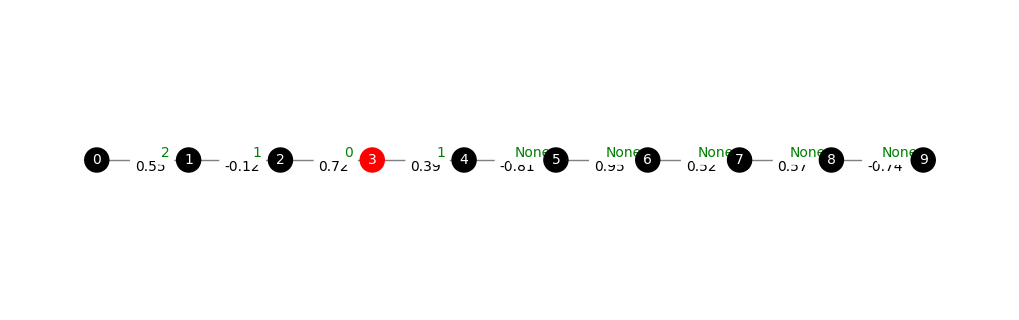

In [4]:
graph_type = "line"
G = get_graph(n_qubits, rng, graph_type)

positions = get_positions(n_qubits, graph_type)

# エッジラベルを作成
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
# edge_interaction_order_labels = {
#     edge: f"{G.edges[edge]['interaction_order']}" for edge in G.edges
# }
edge_cnot_order_labels = {edge: f"{G.edges[edge]['cnot']['order']}" for edge in G.edges}

# グラフを描画
plt.figure(figsize=(10, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["hadamard"] else "black" for node in G.nodes],
    node_size=300,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# エッジの重みを描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# エッジの 'interaction_order' 属性を描画
# nx.draw_networkx_edge_labels(
#     G,
#     pos=positions,
#     edge_labels=edge_interaction_order_labels,
#     font_size=10,
#     font_color="blue",
#     label_pos=0.4,
#     verticalalignment="bottom",
# )

# エッジの 'cnot' 'order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_cnot_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.8,
    verticalalignment="bottom",
)

plt.show()

In [5]:
# Option1: Use IBM Quantum backend.
# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
service = QiskitRuntimeService()
# backend_qpu = service.least_busy(simulator=False, operational=True)
backend_qpu = service.backend("ibm_marrakesh")

# Option2: Use local AerSimulator as the backend.
backend_sim = AerSimulator()
noise_model = NoiseModel.from_backend(backend_qpu)
backend_sim_noisy = AerSimulator(noise_model=noise_model)

print(f"Using backend QPU: {backend_qpu}")
print(f"Using backend simulator: {backend_sim}")
print(f"Using backend noisy simulator: {backend_sim_noisy}")

Using backend QPU: <IBMBackend('ibm_marrakesh')>
Using backend simulator: AerSimulator('aer_simulator')
Using backend noisy simulator: AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['measure', 'sx', 'reset', 'id', 'x', 'cz']>)


## Trotter simulation (exact)

In [6]:
probs_exact = []
heisenberg_exact = HeisenbergModel(n_qubits, G)

for t in times:
    print(f"processing {np.where(times == t)[0][0]}")
    prob_exact = heisenberg_exact.exact_simulation(t, phase=0)
    probs_exact.append(prob_exact)

processing 0
processing 1
processing 2
processing 3
processing 4
processing 5
processing 6
processing 7
processing 8
processing 9
processing 10
processing 11
processing 12
processing 13
processing 14
processing 15
processing 16
processing 17
processing 18
processing 19
processing 20
processing 21
processing 22
processing 23
processing 24
processing 25
processing 26
processing 27
processing 28
processing 29
processing 30
processing 31
processing 32
processing 33
processing 34
processing 35
processing 36
processing 37
processing 38
processing 39
processing 40
processing 41
processing 42
processing 43
processing 44
processing 45
processing 46
processing 47
processing 48
processing 49


## Trotter simulation (Simulator, Noise free)

In [7]:
heisenberg_sim = HeisenbergModel(n_qubits, G, backend_sim)
circuits = []
exec_circuits = []

for t in times:
    print(f"processing {np.where(times == t)[0][0]}")
    n_steps = get_n_steps(t)

    circuit, exec_circuit = heisenberg_sim.get_trotter_simulation_circuit(
        t, n_steps, phase=0
    )
    circuits.append(circuit)
    exec_circuits.append(exec_circuit)

processing 0
processing 1
processing 2
processing 3
processing 4
processing 5
processing 6
processing 7
processing 8
processing 9
processing 10
processing 11
processing 12
processing 13
processing 14
processing 15
processing 16
processing 17
processing 18
processing 19
processing 20
processing 21
processing 22
processing 23
processing 24
processing 25
processing 26
processing 27
processing 28
processing 29
processing 30
processing 31
processing 32
processing 33
processing 34
processing 35
processing 36
processing 37
processing 38
processing 39
processing 40
processing 41
processing 42
processing 43
processing 44
processing 45
processing 46
processing 47
processing 48
processing 49


In [8]:
with Batch(backend=backend_sim):
    sampler = Sampler()
    # Turn on dynamical decoupling.
    sampler.options.dynamical_decoupling.enable = True

    # Run job.
    job = sampler.run(exec_circuits)
    print(f"job_id: {job.job_id()}")

job_id: 7ae39f39-f737-4227-bce6-e3d2109746ed


/Users/yutotakaki/Desktop/fourier_learning_ibm/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [9]:
# Post-processing
probs_sim = []

for result in job.result():
    prob0 = get_prob0(result, n_qubits)
    probs_sim.append(prob0)

## Trotter simulation (Simulator, Noisy)

In [10]:
heisenberg_sim_noisy = HeisenbergModel(n_qubits, G, backend_sim)
circuits = []
exec_circuits = []

for t in times:
    n_steps = get_n_steps(t)

    circuit, exec_circuit = heisenberg_sim_noisy.get_trotter_simulation_circuit(
        t, n_steps, phase=0
    )
    circuits.append(circuit)
    exec_circuits.append(exec_circuit)

In [ ]:
with Batch(backend=backend_sim_noisy):
    sampler = Sampler()
    # Turn on dynamical decoupling.
    sampler.options.dynamical_decoupling.enable = True

    # Run job.
    job = sampler.run(exec_circuits)
    print(f"job_id: {job.job_id()}")

job_id: bd8e5c13-95a6-4ae1-b60b-e5fe533f36aa


/Users/yutotakaki/Desktop/fourier_learning_ibm/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


: 

In [12]:
# Post-processing
probs_sim_noisy = []

for result in job.result():
    prob0 = get_prob0(result, n_qubits)
    probs_sim_noisy.append(prob0)

: 

: 

## Trotter simulation (QPU)

In [13]:
heisenberg_qpu = HeisenbergModel(n_qubits, G, backend_qpu)
circuits_qpu = []
exec_circuits_qpu = []

initial_layout = get_initial_layout(n_qubits, graph_type, backend_qpu.name)


for t in times:
    n_steps = get_n_steps(t)

    circuit, exec_circuit = heisenberg_qpu.get_trotter_simulation_circuit(
        t, n_steps, phase=0, initial_layout=initial_layout
    )
    circuits_qpu.append(circuit)
    exec_circuits_qpu.append(exec_circuit)

before transpile
circuit depth: 19
count_ops: OrderedDict([('cx', 26), ('rx', 10), ('rz', 10), ('rzx', 10), ('measure', 8), ('h', 2), ('barrier', 1)])


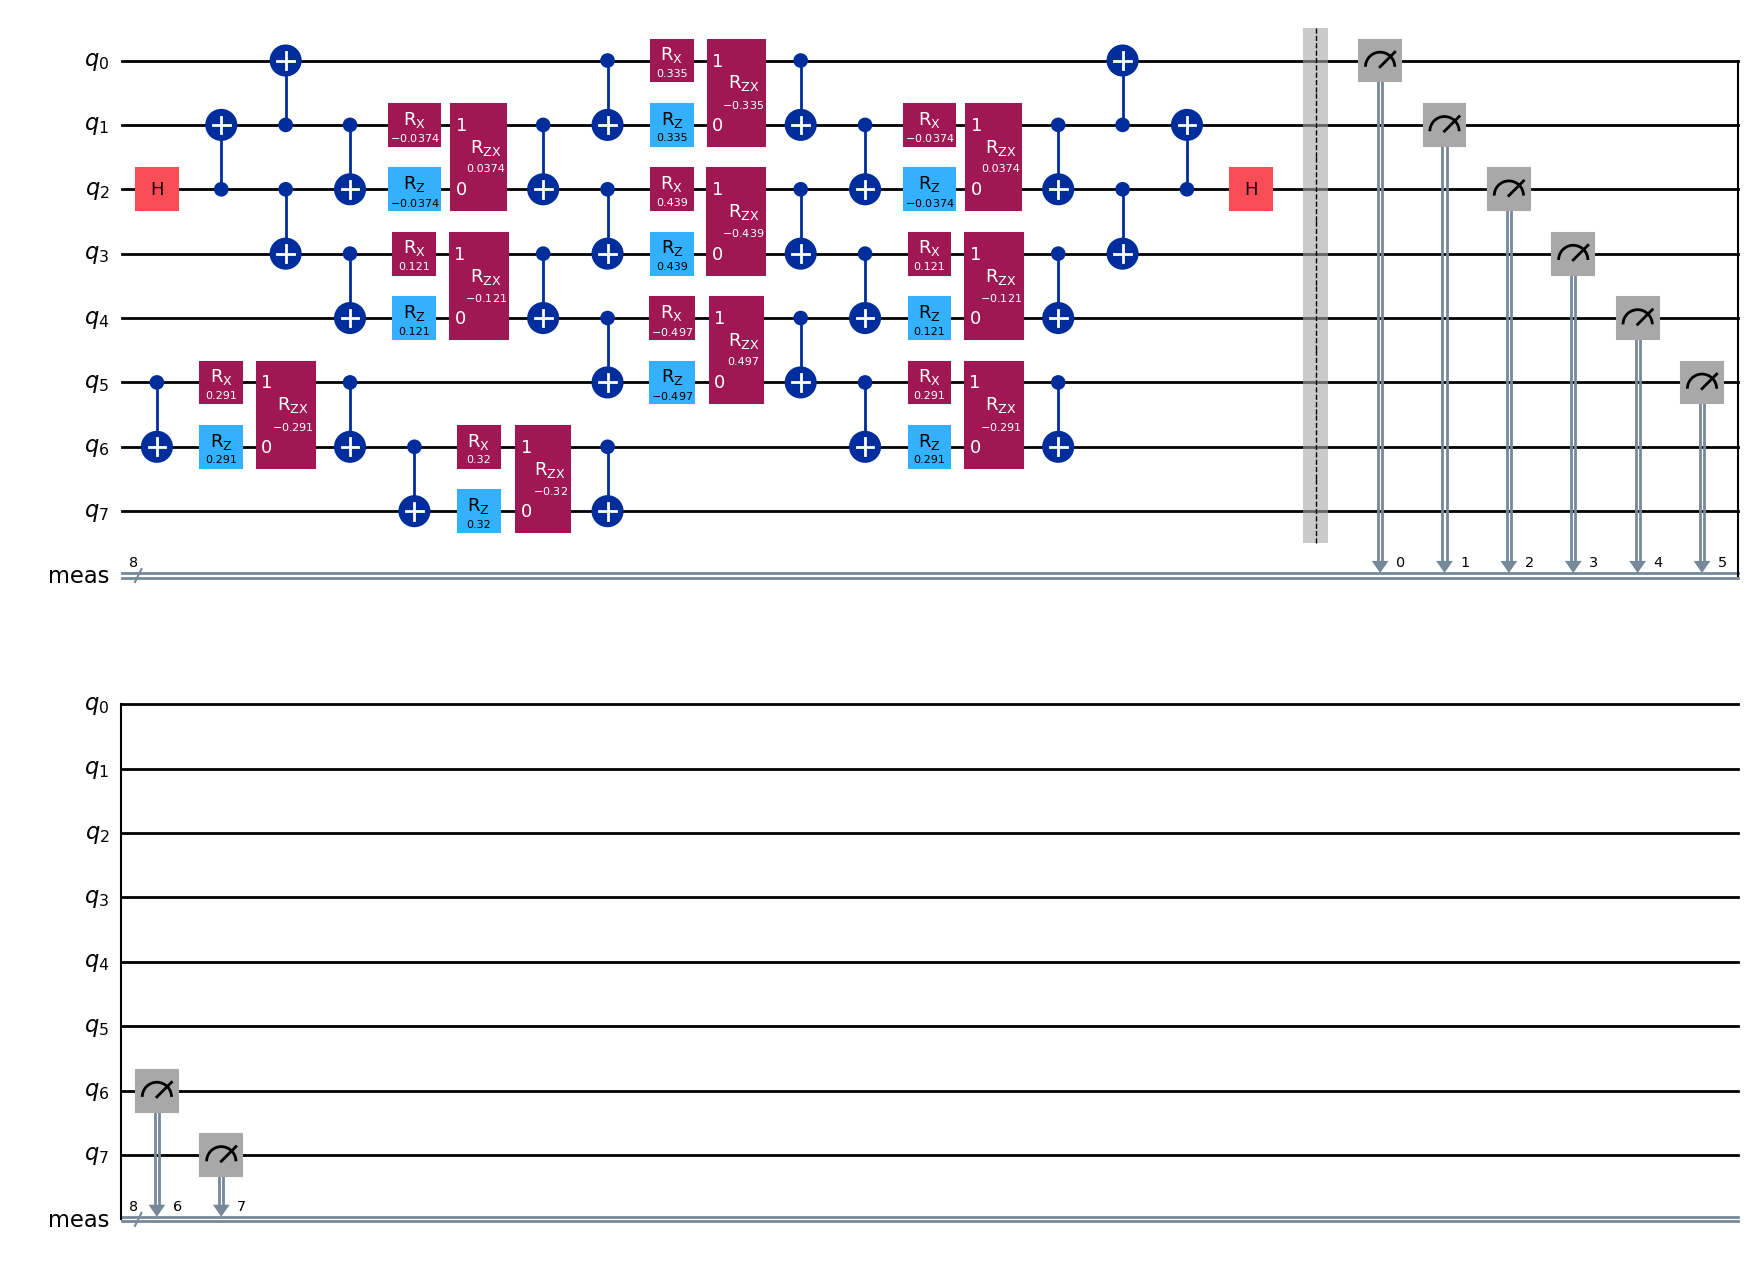

In [14]:
k = 5

print("before transpile")
print(f"circuit depth: {circuits_qpu[k].depth()}")
print(f"count_ops: {circuits_qpu[k].count_ops()}")
circuits_qpu[k].draw("mpl")

after transpile
circuit depth: 49
count_ops: OrderedDict([('sx', 92), ('rz', 76), ('cz', 36), ('measure', 8), ('x', 2), ('barrier', 1)])


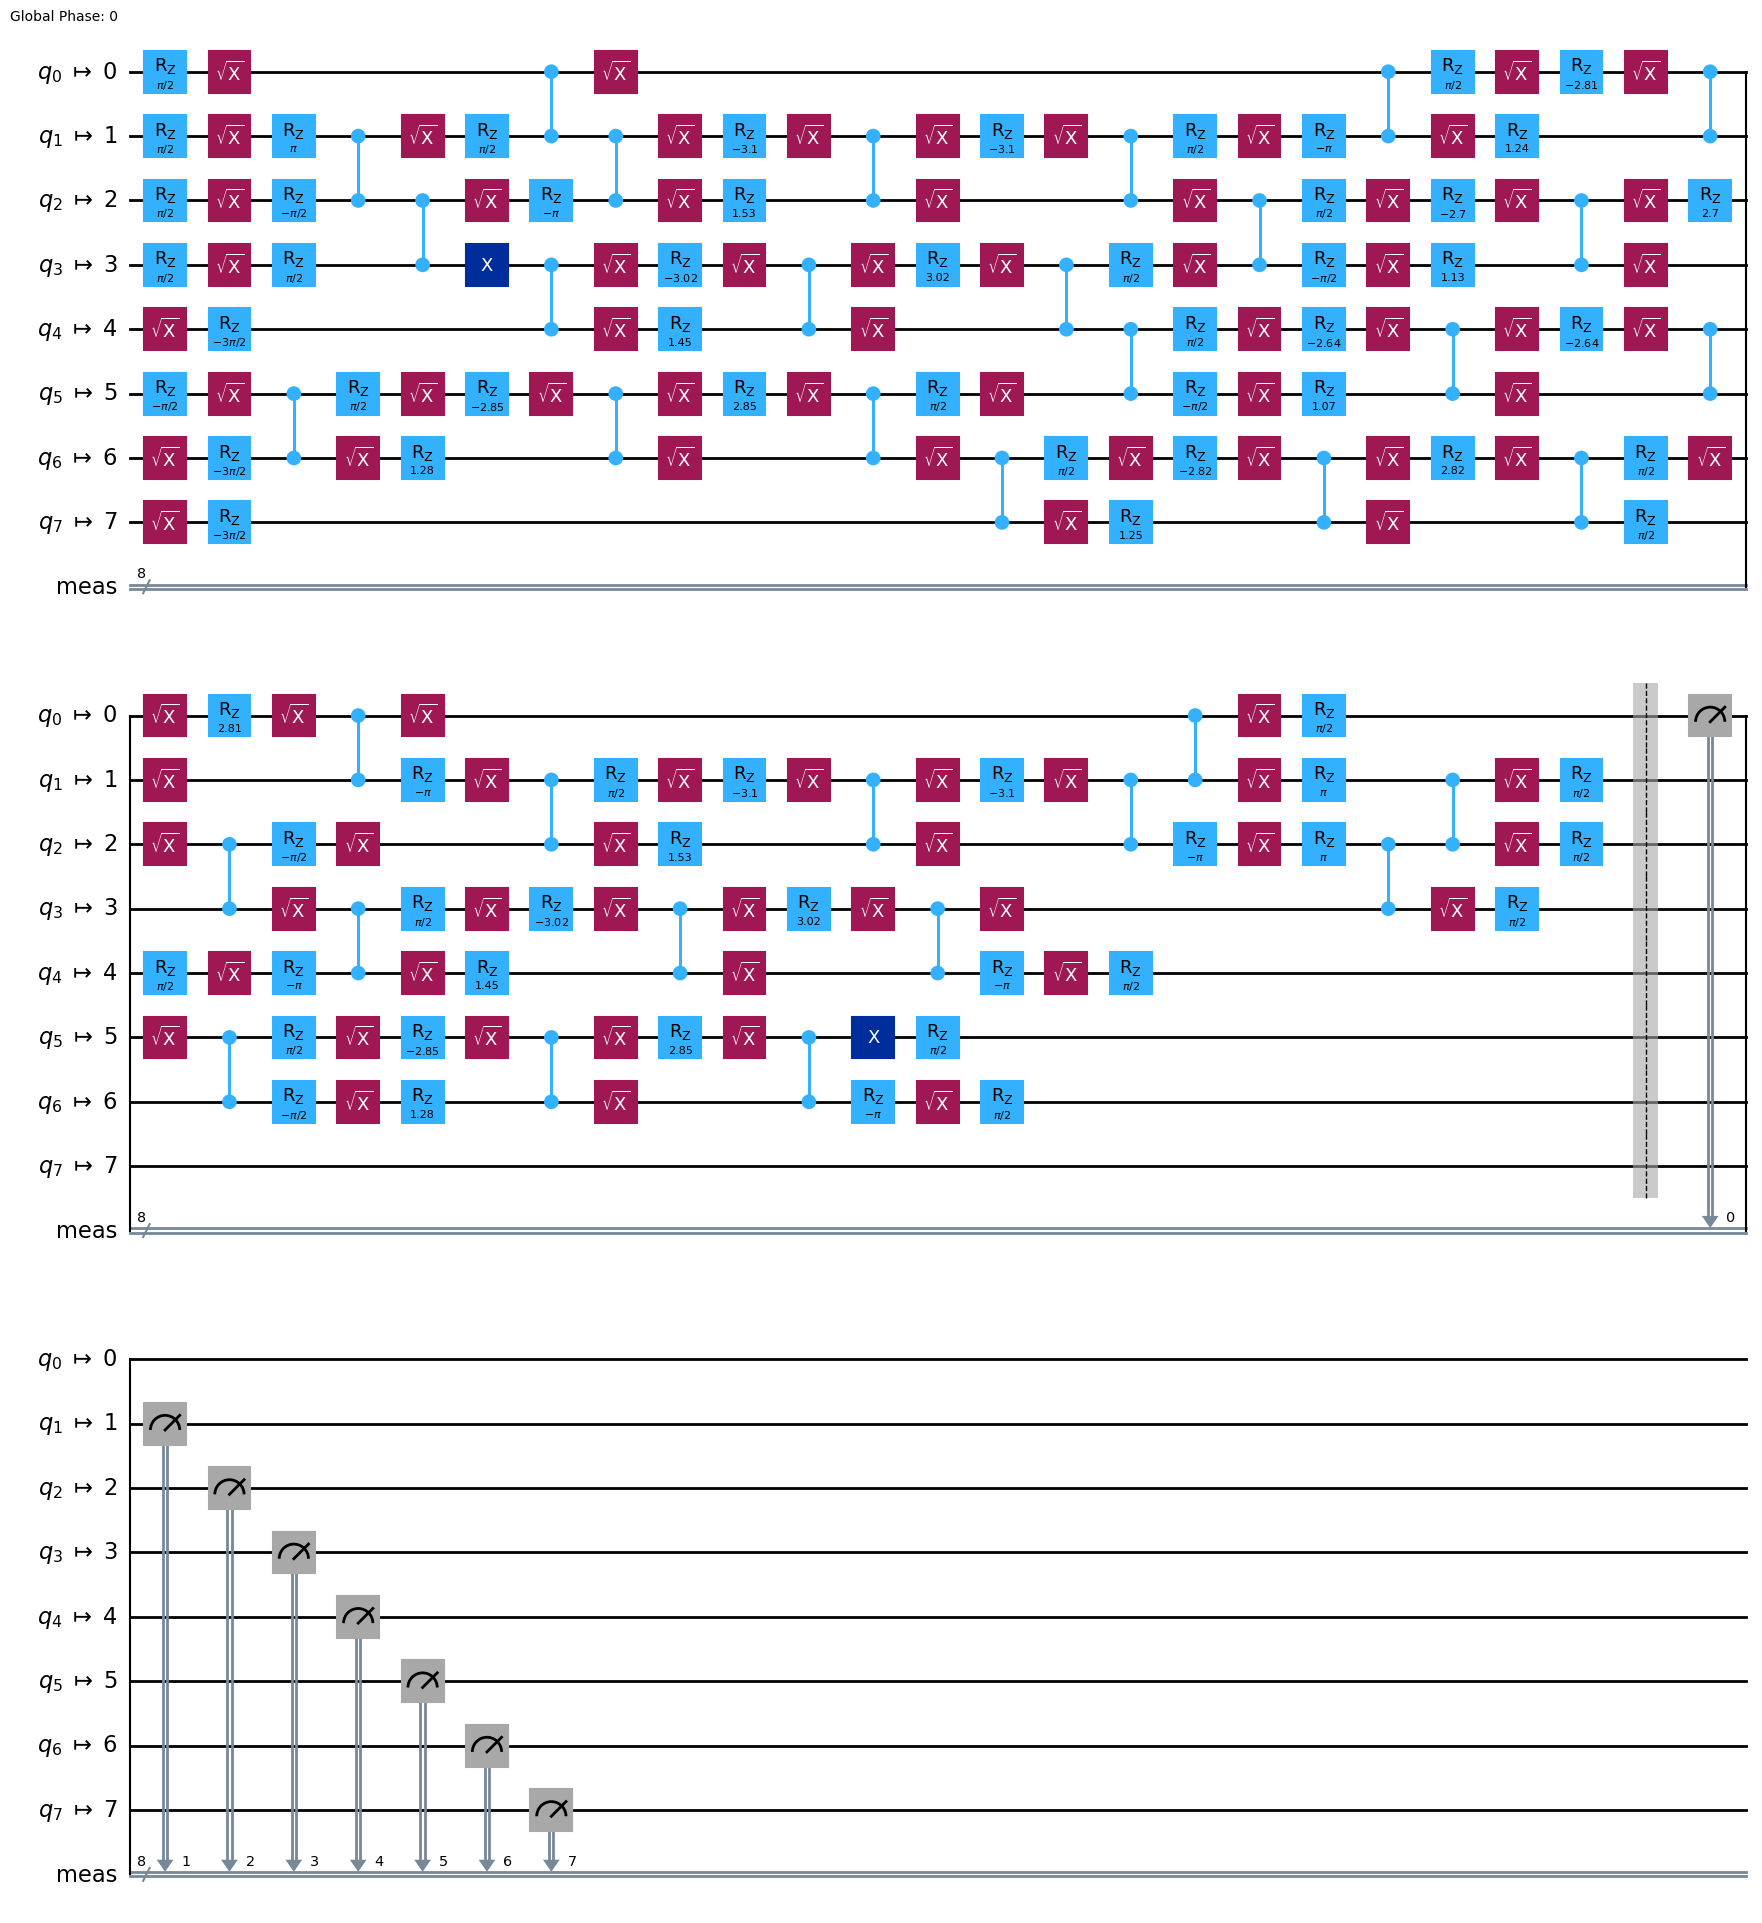

In [15]:
print("after transpile")
print(f"circuit depth: {exec_circuits_qpu[k].depth()}")
print(f"count_ops: {exec_circuits_qpu[k].count_ops()}")
exec_circuits_qpu[k].draw("mpl", idle_wires=False)

In [21]:
# Run a job in a batch
mit = mthree.M3Mitigation(backend_qpu)
with Batch(backend=backend_qpu) as batch:
    sampler = Sampler()
    mit.cals_from_system(runtime_mode=batch)
    # Turn on dynamical decoupling.
    sampler.options.dynamical_decoupling.enable = True

    # Run job.
    job = sampler.run(exec_circuits_qpu)
    print(f"job_id: {job.job_id()}")

job_id: cx0ywmjrkac00081j930


In [ ]:
current_time = (
    datetime.now(timezone.utc).isoformat(timespec="minutes").replace("+00:00", "Z")
)

path = f"./test_data/{current_time}_{n_qubits}_{backend_qpu.name}_{graph_type}"
os.makedirs(path, exist_ok=True)

with open(f"{path}/job_id_qpu.txt", "w") as f:
    f.write(job.job_id())

print(f"current_time: {current_time}")
print(f"Saving data to {path}")

current_time: 2024-11-23T15:20Z
Saving data to ./test_data/2024-11-23T15:20Z_4_ibm_marrakesh_line


In [25]:
batch.status()

'Closed'

In [28]:
# This cell can be finished after the queue is finished and the batch is started.
started_at = batch.details()["started_at"]
print(f"started_at: {started_at}")

mit.cals_to_file(f"{path}/calibrations_{started_at}.json")

started_at: 2024-11-23T15:01:32.675Z


## Below should be run after first running

In [29]:
# Copy and paste the outputs of the above cells
current_time = "2024-11-23T15:20Z"
started_at = "2024-11-23T15:01:32.675Z"

path = f"./test_data/{current_time}_{n_qubits}_{backend_qpu.name}_{graph_type}"

In [30]:
# Retrieve the job
with open(f"{path}/job_id_qpu.txt", "r") as f:
    job_id = f.read()

job = service.job(job_id)

In [31]:
# Apply mititation
probs_qpu_nmit = []
probs_qpu_mit = []

cals_file = f"{path}/calibrations_{started_at}.json"
mit = mthree.M3Mitigation(backend_qpu)
mit.cals_from_file(cals_file)

for result in job.result():
    prob0_nmit, prob0_mit = get_prob0(result, n_qubits, mit)
    if prob0_mit >= 1:
        prob0_mit = 1

    probs_qpu_nmit.append(prob0_nmit)
    probs_qpu_mit.append(prob0_mit)

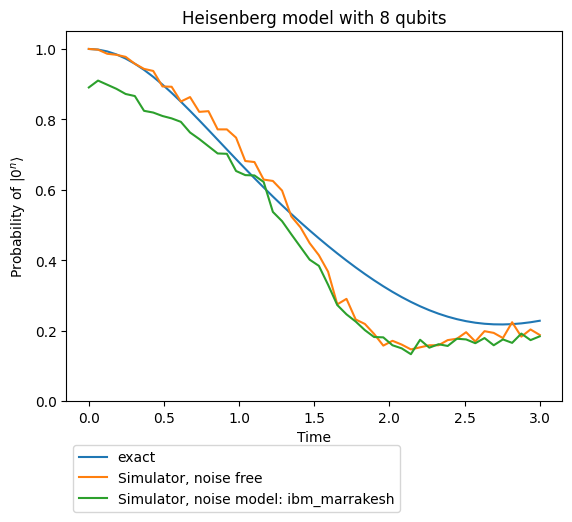

In [16]:
# Plot the results
plt.plot(times, probs_exact, label="exact")
plt.plot(times, probs_sim, label=f"Simulator, noise free")
plt.plot(times, probs_sim_noisy, label=f"Simulator, noise model: {backend_qpu.name}")
# plt.plot(times, probs_qpu_nmit, label=f"QPU: {backend_qpu.name} (no mitigation)")
# plt.plot(times, probs_qpu_mit, label=f"QPU: {backend_qpu.name} (with mitigation)")
plt.title(f"Heisenberg model with {n_qubits} qubits")
plt.ylim(0, 1.05)
plt.xlabel("Time")
plt.ylabel("Probability of $|0^n\\rangle$")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.show()